In [1]:
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications import VGG19
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input
import time

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

170498071/170498071 [==============================] - 13s 0us/step
(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [3]:
NUM_CLASSES = len(np.unique(y_train))
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 64

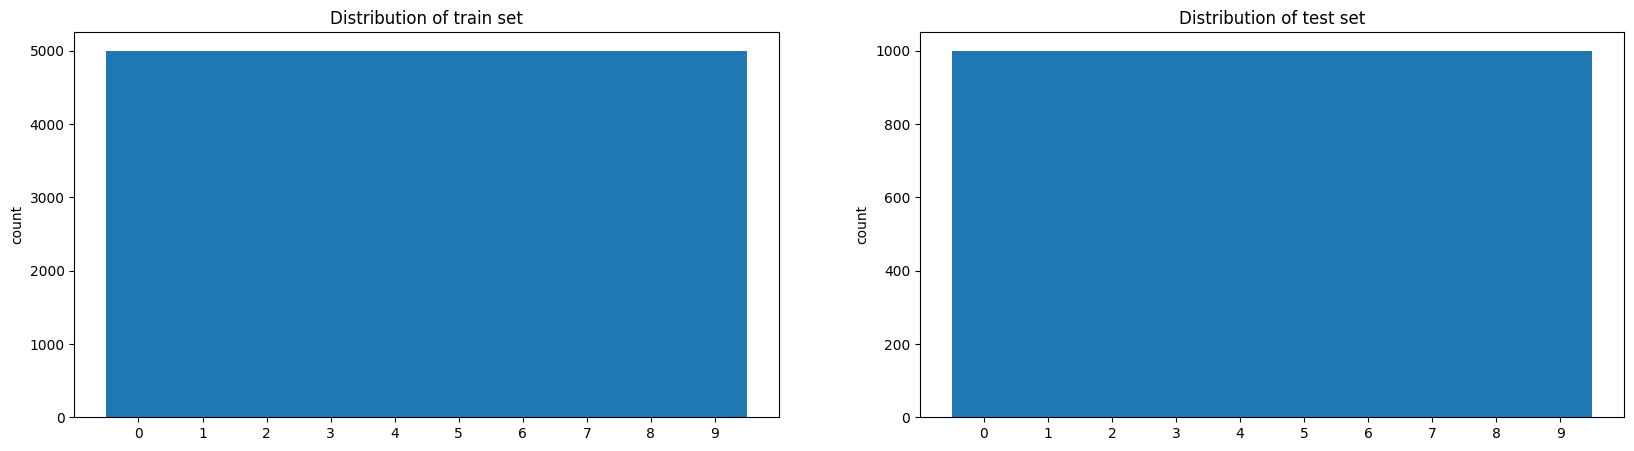

In [4]:
figure = plt.figure(figsize=(20, 5))
figure.add_subplot(1, 2, 1)
plt.hist(y_train, bins=np.arange(11) - 0.5)
plt.xticks(np.arange(10))
plt.ylabel('count')
plt.title('Distribution of train set');

figure.add_subplot(1, 2, 2)
plt.hist(y_test, bins=np.arange(11) - 0.5)
plt.xticks(np.arange(10))
plt.ylabel('count')
plt.title('Distribution of test set');

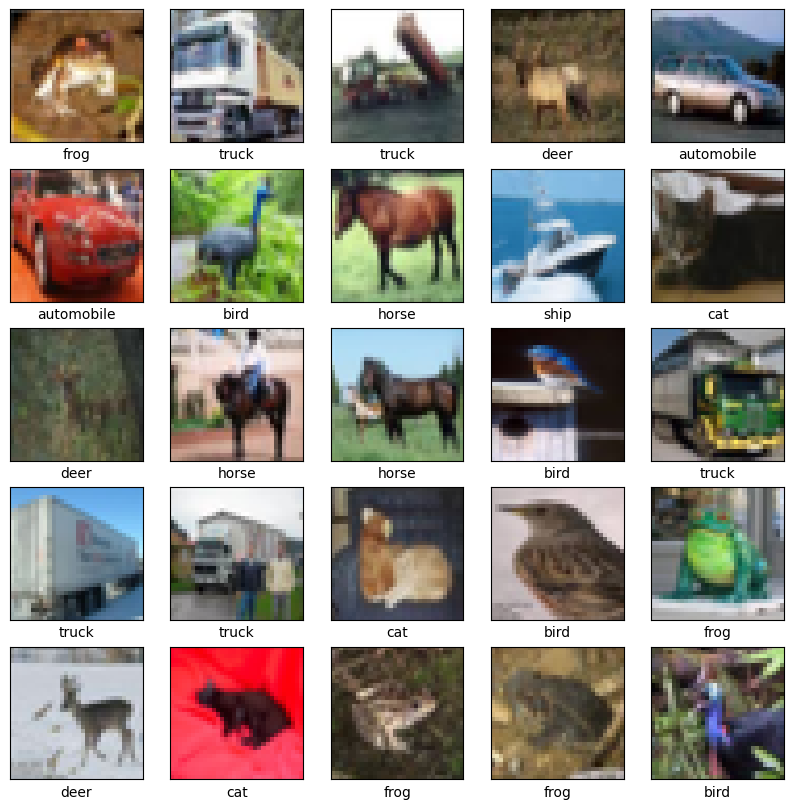

In [5]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(10,10))
for i in range(25):
   plt.subplot(5,5,i+1)
   plt.xticks([])
   plt.yticks([])
   plt.grid(False)
   plt.imshow(X_train[i])
   plt.xlabel(class_names[y_train[i][0]])
plt.show()

In [6]:
y_train = to_categorical(y_train, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)

In [7]:
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [8]:
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1)

In [9]:
print((X_train.shape,y_train.shape))
print((X_val.shape,y_val.shape))
print((X_test.shape,y_test.shape))

((45000, 32, 32, 3), (45000, 10))
((5000, 32, 32, 3), (5000, 10))
((10000, 32, 32, 3), (10000, 10))


In [10]:
data_gen = ImageDataGenerator(horizontal_flip=False)
train_iter = data_gen.flow(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    shuffle=True
)
val_iter = data_gen.flow(
    X_val,
    y_val,
    batch_size=BATCH_SIZE,
    shuffle=True
)
test_iter = data_gen.flow(
    X_test,
    y_test,
    batch_size=BATCH_SIZE,
    shuffle=True
)

In [11]:
def resize_generator(data_iter):
    for images, labels in data_iter:
        resized_images = tf.image.resize(images, (224, 224), method=tf.image.ResizeMethod.BILINEAR)
        yield resized_images, labels


gen_train = resize_generator(train_iter)
gen_val = resize_generator(val_iter)
gen_test = resize_generator(test_iter)

resized_X_train, resized_y_train = next(gen_train)

In [12]:
resized_y_train.shape

(64, 10)

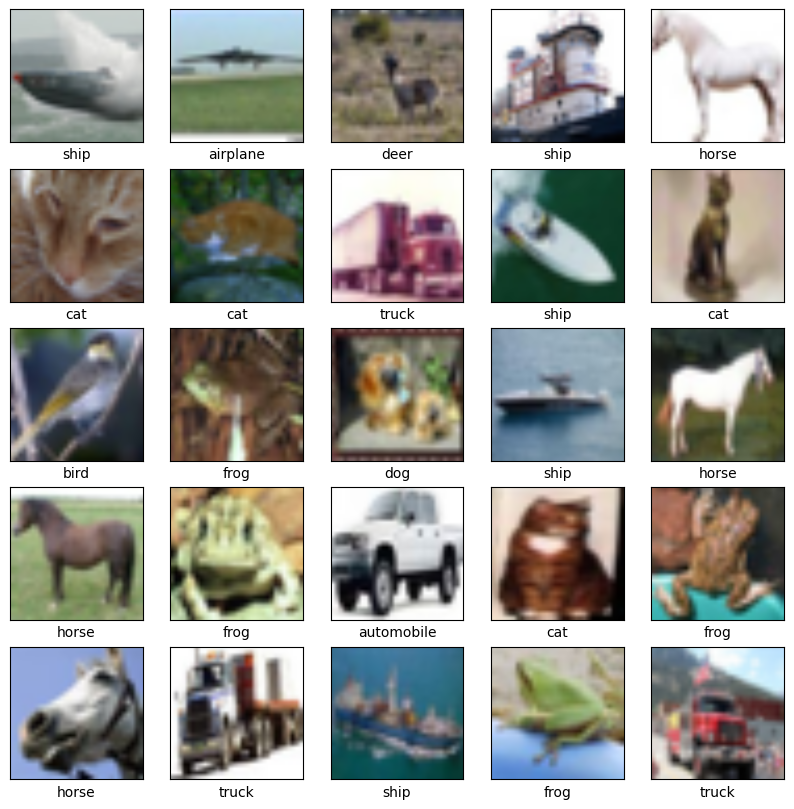

In [13]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(10,10))
for i in range(25):
   plt.subplot(5,5,i+1)
   plt.xticks([])
   plt.yticks([])
   plt.grid(False)
   plt.imshow(resized_X_train[i])
   plt.xlabel(class_names[resized_y_train[i].argmax(axis = 0)])
plt.show()

In [22]:
model = VGG19(input_shape= (224, 224, 3),
                                      weights= 'imagenet',
                                      include_top= False,
                                      pooling = "avg"
                                      )


# for layer in model.layers:
#     layer.trainable = False

for layer in model.layers:
    if layer.name.startswith('block5_'):
        layer.trainable = True
    else:
        layer.trainable = False


x = keras.layers.Flatten()(model.output)
x = keras.layers.Dense(256,activation='elu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = keras.models.Model(model.input, x)


80134624/80134624 [==============================] - 4s 0us/step


In [23]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [24]:
# checkpoint_cb = keras.callbacks.ModelCheckpoint("model.keras", save_best_only=True, monitor="val_loss")

# early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# initial_learning_rate = 0.001

# def scheduler(epoch, lr):
#     if epoch % 10 == 0:
#         return lr * 0.9
#     else:
#         return lr

# lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [25]:
training_times = []
validation_times = []


class TimeHistory(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.epoch_start_time
        training_times.append(epoch_time)
        print(f"Epoch {epoch+1} training time: {epoch_time:.2f} seconds")

    def on_test_begin(self, logs=None):
        self.test_start_time = time.time()

    def on_test_end(self, logs=None):
        test_time = time.time() - self.test_start_time
        validation_times.append(test_time)
        print(f"\nValidation time: {test_time:.2f} seconds")
time_callback = TimeHistory()

In [26]:
for x, y in gen_val:
    print(x.shape, y.shape)
    break


(64, 224, 224, 3) (64, 10)


In [27]:
history = model.fit(gen_train,steps_per_epoch=len(X_train) // BATCH_SIZE, validation_data = gen_val , validation_steps=len(X_val) // BATCH_SIZE ,epochs=10, callbacks=[time_callback], verbose=1)

Epoch 1/10
703/703 [==============================] - ETA: 0s - loss: 1.1285 - accuracy: 0.5977
Validation time: 25.29 seconds
Epoch 1 training time: 316.45 seconds
703/703 [==============================] - 316s 426ms/step - loss: 1.1285 - accuracy: 0.5977 - val_loss: 0.8183 - val_accuracy: 0.7283
Epoch 2/10
703/703 [==============================] - ETA: 0s - loss: 0.6441 - accuracy: 0.7770
Validation time: 25.13 seconds
Epoch 2 training time: 284.09 seconds
703/703 [==============================] - 284s 404ms/step - loss: 0.6441 - accuracy: 0.7770 - val_loss: 0.5861 - val_accuracy: 0.7956
Epoch 3/10
703/703 [==============================] - ETA: 0s - loss: 0.4729 - accuracy: 0.8374
Validation time: 25.30 seconds
Epoch 3 training time: 297.83 seconds
703/703 [==============================] - 298s 424ms/step - loss: 0.4729 - accuracy: 0.8374 - val_loss: 0.5217 - val_accuracy: 0.8241
Epoch 4/10
703/703 [==============================] - ETA: 0s - loss: 0.3653 - accuracy: 0.8752
Vali

In [28]:
avg_training_time = sum(training_times) / len(training_times)
avg_validation_time = sum(validation_times) / len(validation_times)
print(f'Average training time per epoch: {avg_training_time:.2f} seconds')
print(f'Average validation time per epoch: {avg_validation_time:.2f} seconds')


Average training time per epoch: 298.66 seconds
Average validation time per epoch: 25.21 seconds


In [29]:
import plotly.express as px

# metric: 'accuracy' or 'loss'
def display_curves(history, metric):
  df = pd.DataFrame(history.history[metric], columns=[metric])
  df['val_'+metric] = history.history['val_'+metric]
  fig = px.line(df, x= df.index+1, y= [metric, 'val_'+metric])
  fig.update_layout(xaxis_title='Epochs', yaxis_title=metric)
  fig.show()

In [30]:
display_curves(history, 'loss')

In [31]:
display_curves(history, 'accuracy')